In [3]:
# Setup libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import re
from bs4 import BeautifulSoup
from urllib import request

from __future__ import print_function
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

import spacy

In [4]:
# import public comments file
# regulations.gov Docket ID #HHS-ONC-2019-0002

comments = pd.read_csv('data/lq3-2tlj-4cxo_Public Submission.csv')
comments.head()

Document ID Agency ID          Docket ID Tracking Number  \
0  HHS-ONC-2019-0002-0002       HHS  HHS-ONC-2019-0002   1k3-98l4-id47   
1  HHS-ONC-2019-0002-0003       HHS  HHS-ONC-2019-0002   1k3-98l4-yij2   
2  HHS-ONC-2019-0002-0004       HHS  HHS-ONC-2019-0002   1k3-98lc-p12e   
3  HHS-ONC-2019-0002-0005       HHS  HHS-ONC-2019-0002   1k3-98lq-jyu5   
4  HHS-ONC-2019-0002-0006       HHS  HHS-ONC-2019-0002   1k3-98lr-m0vc   

       Document Type        Posted Date  Is Withdrawn?  \
0  Public Submission  2019-03-06T05:00Z          False   
1  Public Submission  2019-03-06T05:00Z          False   
2  Public Submission  2019-03-06T05:00Z          False   
3  Public Submission  2019-03-06T05:00Z          False   
4  Public Submission  2019-03-06T05:00Z          False   

   Federal Register Number  FR Citation                           Title  ...  \
0                      NaN          NaN  Comment on FR Doc # 2019-02224  ...   
1                      NaN          NaN  Comment on FR Doc # 2019-02224  ...   
2                      NaN          NaN  Comment on FR Doc # 2019-02224  ...   
3                      NaN          NaN  Comment on FR Doc # 2019-02224  ...   
4                      NaN          NaN  Comment on FR Doc # 2019-02224  ...   

   Government Agency  Government Agency Type  \
0                NaN                     NaN   
1                NaN                     NaN   
2                NaN                     NaN   
3                NaN                     NaN   
4                NaN                     NaN   

                                             Comment Category  \
0  On behalf of the EHR Association and our more ...      NaN   
1  Comment: RIN 0945-AA00\nSimilar to mandated HI...      NaN   
2  21st Century Cures Act is absolutely for patie...      NaN   
3  As a practicing physician, I strongly support ...      NaN   
4  I am concerned about the "recovering costs rea...      NaN   

   Restrict Reason Type  Restrict Reason  Reason Withdrawn Content Files  \
0                   NaN              NaN               NaN           NaN   
1                   NaN              NaN               NaN           NaN   
2                   NaN              NaN               NaN           NaN   
3                   NaN              NaN               NaN           NaN   
4                   NaN              NaN               NaN           NaN   

                                    Attachment Files  \
0  https://downloads.regulations.gov/HHS-ONC-2019...   
1  https://downloads.regulations.gov/HHS-ONC-2019...   
2                                                NaN   
3                                                NaN   
4                                                NaN   

           Display Properties (Name, Label, Tooltip)  
0  pageCount, Page Count, Number of pages In the ...  
1  pageCount, Page Count, Number of pages In the ...  
2  pageCount, Page Count, Number of pages In the ...  
3  pageCount, Page Count, Number of pages In the ...  
4  pageCount, Page Count, Number of pages In the ...  

[5 rows x 60 columns]

In [5]:
# Retrieving column names to check for relevance
list(comments.columns)

['Document ID',
 'Agency ID',
 'Docket ID',
 'Tracking Number',
 'Document Type',
 'Posted Date',
 'Is Withdrawn?',
 'Federal Register Number',
 'FR Citation',
 'Title',
 'Comment Start Date',
 'Comment Due Date',
 'Allow Late Comments',
 'Comment on Document ID',
 'Effective Date',
 'Implementation Date',
 'Postmark Date',
 'Received Date',
 'Author Date',
 'Related RIN(s)',
 'Authors',
 'CFR',
 'Abstract',
 'Legacy ID',
 'Media',
 'Document Subtype',
 'Exhibit Location',
 'Exhibit Type',
 'Additional Field 1',
 'Additional Field 2',
 'Topics',
 'Duplicate Comments',
 'OMB/PRA Approval Number',
 'Page Count',
 'Page Length',
 'Paper Width',
 'Special Instructions',
 'Source Citation',
 'Start End Page',
 'Subject',
 'First Name',
 'Last Name',
 'City',
 'State/Province',
 'Zip/Postal Code',
 'Country',
 'Organization Name',
 'Submitter Representative',
 "Representative's Address",
 "Representative's City, State & Zip",
 'Government Agency',
 'Government Agency Type',
 'Comment',
 'Cat

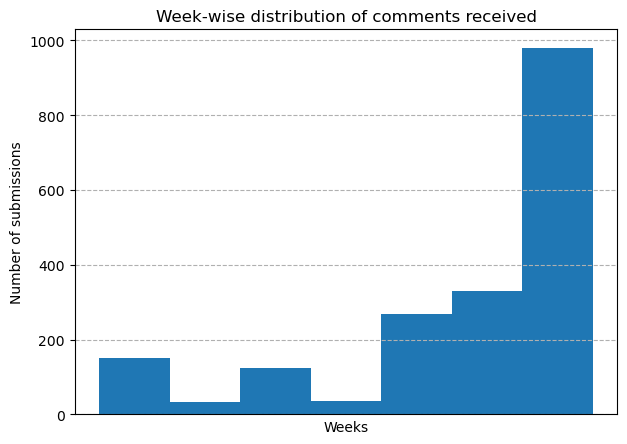

In [6]:
fig, ax = plt.subplots(figsize = (7, 5))  

comments['Received Date'].hist(bins = 7)

ax.xaxis.set_tick_params(labelbottom = False)
ax.set_xticks([])
plt.xlabel("Weeks", fontsize = 10)
plt.ylabel("Number of submissions", fontsize = 10)
plt.title("Week-wise distribution of comments received", fontsize = 12)
plt.grid(linestyle = '--')
# plt.savefig("project_data/output/comment_submissions.jpg", dpi = 200)

In [7]:
# Subsetting to columns of interest

sub_comments = comments[['Document ID', 'Comment', 'Attachment Files']].copy()
sub_comments

Document ID  \
0     HHS-ONC-2019-0002-0002   
1     HHS-ONC-2019-0002-0003   
2     HHS-ONC-2019-0002-0004   
3     HHS-ONC-2019-0002-0005   
4     HHS-ONC-2019-0002-0006   
...                      ...   
1918  HHS-ONC-2019-0002-1921   
1919  HHS-ONC-2019-0002-1922   
1920  HHS-ONC-2019-0002-1923   
1921  HHS-ONC-2019-0002-1924   
1922  HHS-ONC-2019-0002-1925   

                                                Comment  \
0     On behalf of the EHR Association and our more ...   
1     Comment: RIN 0945-AA00\nSimilar to mandated HI...   
2     21st Century Cures Act is absolutely for patie...   
3     As a practicing physician, I strongly support ...   
4     I am concerned about the "recovering costs rea...   
...                                                 ...   
1918  Please see the attached comments from the Amer...   
1919  Please accept the attached comments on behalf ...   
1920  The staff of the Federal Trade Commission Offi...   
1921  Thank you for the opportunity to provide comme...   
1922                               See attached file(s)   

                                       Attachment Files  
0     https://downloads.regulations.gov/HHS-ONC-2019...  
1     https://downloads.regulations.gov/HHS-ONC-2019...  
2                                                   NaN  
3                                                   NaN  
4                                                   NaN  
...                                                 ...  
1918  https://downloads.regulations.gov/HHS-ONC-2019...  
1919  https://downloads.regulations.gov/HHS-ONC-2019...  
1920  https://downloads.regulations.gov/HHS-ONC-2019...  
1921  https://downloads.regulations.gov/HHS-ONC-2019...  
1922  https://downloads.regulations.gov/HHS-ONC-2019...  

[1923 rows x 3 columns]

In [8]:
sub_comments.shape

(1923, 3)

In [9]:
# Calculating the number of words per comment

sub_comments['nwords'] = [len(x.split()) for x in sub_comments['Comment'].tolist()]
sub_comments

Document ID  \
0     HHS-ONC-2019-0002-0002   
1     HHS-ONC-2019-0002-0003   
2     HHS-ONC-2019-0002-0004   
3     HHS-ONC-2019-0002-0005   
4     HHS-ONC-2019-0002-0006   
...                      ...   
1918  HHS-ONC-2019-0002-1921   
1919  HHS-ONC-2019-0002-1922   
1920  HHS-ONC-2019-0002-1923   
1921  HHS-ONC-2019-0002-1924   
1922  HHS-ONC-2019-0002-1925   

                                                Comment  \
0     On behalf of the EHR Association and our more ...   
1     Comment: RIN 0945-AA00\nSimilar to mandated HI...   
2     21st Century Cures Act is absolutely for patie...   
3     As a practicing physician, I strongly support ...   
4     I am concerned about the "recovering costs rea...   
...                                                 ...   
1918  Please see the attached comments from the Amer...   
1919  Please accept the attached comments on behalf ...   
1920  The staff of the Federal Trade Commission Offi...   
1921  Thank you for the opportunity to provide comme...   
1922                               See attached file(s)   

                                       Attachment Files  nwords  
0     https://downloads.regulations.gov/HHS-ONC-2019...     191  
1     https://downloads.regulations.gov/HHS-ONC-2019...     141  
2                                                   NaN      36  
3                                                   NaN      64  
4                                                   NaN     316  
...                                                 ...     ...  
1918  https://downloads.regulations.gov/HHS-ONC-2019...      12  
1919  https://downloads.regulations.gov/HHS-ONC-2019...      38  
1920  https://downloads.regulations.gov/HHS-ONC-2019...      22  
1921  https://downloads.regulations.gov/HHS-ONC-2019...      31  
1922  https://downloads.regulations.gov/HHS-ONC-2019...       3  

[1923 rows x 4 columns]

In [10]:
sub_comments['nwords'].describe()

count    1923.000000
mean      114.407176
std       141.083060
min         1.000000
25%        24.000000
50%        61.000000
75%       149.000000
max       864.000000
Name: nwords, dtype: float64

In [11]:
# Dropping all comments that have attachments since text extraction from pdf is required.
# This affects selected sample.

temp = sub_comments[sub_comments['Attachment Files'].isnull()]
select_comments = temp[['Document ID', 'Comment', 'nwords']].copy()
select_comments

Document ID  \
2     HHS-ONC-2019-0002-0004   
3     HHS-ONC-2019-0002-0005   
4     HHS-ONC-2019-0002-0006   
5     HHS-ONC-2019-0002-0007   
6     HHS-ONC-2019-0002-0008   
...                      ...   
1905  HHS-ONC-2019-0002-1908   
1907  HHS-ONC-2019-0002-1910   
1910  HHS-ONC-2019-0002-1913   
1913  HHS-ONC-2019-0002-1916   
1915  HHS-ONC-2019-0002-1918   

                                                Comment  nwords  
2     21st Century Cures Act is absolutely for patie...      36  
3     As a practicing physician, I strongly support ...      64  
4     I am concerned about the "recovering costs rea...     316  
5     The APIs exposed are too limited. Giving the p...      64  
6     In Section C. I. under PROPOSED ADOPTION OF FH...     118  
...                                                 ...     ...  
1905  100% transparency in health care pricing. \n\n...      10  
1907  There is no reason that prices for medical car...      40  
1910  Prices in healthcare should be available for a...      20  
1913   Should be like all retail, total price available       8  
1915  There is VERY wide discrepancies in pricing fo...     305  

[1459 rows x 3 columns]

In [12]:
select_comments['nwords'].describe()

count    1459.000000
mean      133.422892
std       142.244780
min         1.000000
25%        38.000000
50%        78.000000
75%       168.000000
max       864.000000
Name: nwords, dtype: float64

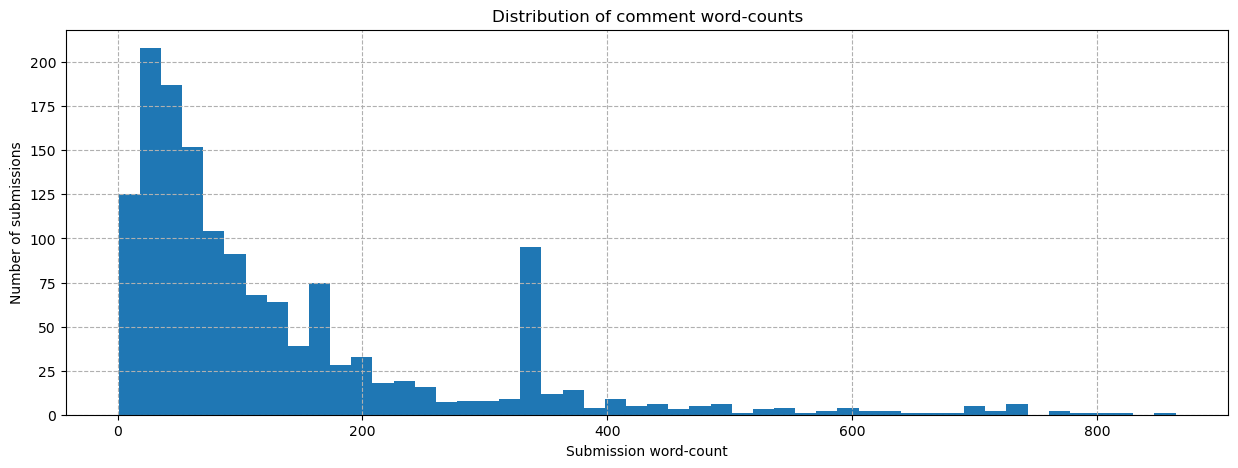

In [13]:
plt.figure(figsize = (15, 5))

select_comments['nwords'].hist(bins = 50)

plt.xlabel("Submission word-count", fontsize = 10)
plt.ylabel("Number of submissions", fontsize = 10)
plt.title("Distribution of comment word-counts", fontsize = 12)
plt.grid(linestyle = '--')
# plt.savefig("project_data/output/word-counts.jpg", dpi = 200)

## Sentiment Analysis using NLTK

In [14]:
# Preparing for sentiment analysis using nltk
# Pre-processing text to remove stop-words

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    processed_text = ' '.join(lemmatized_tokens)
    return processed_text

In [15]:
# Apply the function to the selected comments 

select_comments['processtext'] = select_comments['Comment'].apply(preprocess_text)

In [16]:
# Calculate word-counts for the processed words

select_comments['ptext_nwords'] = [len(x.split()) for x in select_comments['processtext'].tolist()]
select_comments

Document ID  \
2     HHS-ONC-2019-0002-0004   
3     HHS-ONC-2019-0002-0005   
4     HHS-ONC-2019-0002-0006   
5     HHS-ONC-2019-0002-0007   
6     HHS-ONC-2019-0002-0008   
...                      ...   
1905  HHS-ONC-2019-0002-1908   
1907  HHS-ONC-2019-0002-1910   
1910  HHS-ONC-2019-0002-1913   
1913  HHS-ONC-2019-0002-1916   
1915  HHS-ONC-2019-0002-1918   

                                                Comment  nwords  \
2     21st Century Cures Act is absolutely for patie...      36   
3     As a practicing physician, I strongly support ...      64   
4     I am concerned about the "recovering costs rea...     316   
5     The APIs exposed are too limited. Giving the p...      64   
6     In Section C. I. under PROPOSED ADOPTION OF FH...     118   
...                                                 ...     ...   
1905  100% transparency in health care pricing. \n\n...      10   
1907  There is no reason that prices for medical car...      40   
1910  Prices in healthcare should be available for a...      20   
1913   Should be like all retail, total price available       8   
1915  There is VERY wide discrepancies in pricing fo...     305   

                                            processtext  ptext_nwords  
2     21st century cure act absolutely patient waiti...            22  
3     practicing physician , strongly support propos...            55  
4     concerned `` recovering cost reasonably incurr...           233  
5     apis exposed limited . giving patient role hea...            44  
6     section c. i. proposed adoption fhir dstu2 sta...            89  
...                                                 ...           ...  
1905  100 % transparency health care pricing . 100 %...            12  
1907  reason price medical care ca n't available eve...            23  
1910  price healthcare available see , prudent choic...            12  
1913                like retail , total price available             6  
1915  wide discrepancy pricing healthcare service . ...           180  

[1459 rows x 5 columns]

In [17]:
# Initialise SentimentIntensityAnalyzer() from nltk

sentiment = SentimentIntensityAnalyzer()

In [18]:
# Function to calcuate sentiment scores for each comment

def get_sentiment(text):
    scores = sentiment.polarity_scores(text)
    return pd.Series(scores)

In [19]:
# Apply function to the processed text in select_comments

sentiment_scores_df = select_comments['processtext'].apply(get_sentiment)
comments_withscores = pd.concat([select_comments, sentiment_scores_df], axis=1)
comments_withscores

Document ID  \
2     HHS-ONC-2019-0002-0004   
3     HHS-ONC-2019-0002-0005   
4     HHS-ONC-2019-0002-0006   
5     HHS-ONC-2019-0002-0007   
6     HHS-ONC-2019-0002-0008   
...                      ...   
1905  HHS-ONC-2019-0002-1908   
1907  HHS-ONC-2019-0002-1910   
1910  HHS-ONC-2019-0002-1913   
1913  HHS-ONC-2019-0002-1916   
1915  HHS-ONC-2019-0002-1918   

                                                Comment  nwords  \
2     21st Century Cures Act is absolutely for patie...      36   
3     As a practicing physician, I strongly support ...      64   
4     I am concerned about the "recovering costs rea...     316   
5     The APIs exposed are too limited. Giving the p...      64   
6     In Section C. I. under PROPOSED ADOPTION OF FH...     118   
...                                                 ...     ...   
1905  100% transparency in health care pricing. \n\n...      10   
1907  There is no reason that prices for medical car...      40   
1910  Prices in healthcare should be available for a...      20   
1913   Should be like all retail, total price available       8   
1915  There is VERY wide discrepancies in pricing fo...     305   

                                            processtext  ptext_nwords    neg  \
2     21st century cure act absolutely patient waiti...            22  0.116   
3     practicing physician , strongly support propos...            55  0.081   
4     concerned `` recovering cost reasonably incurr...           233  0.102   
5     apis exposed limited . giving patient role hea...            44  0.075   
6     section c. i. proposed adoption fhir dstu2 sta...            89  0.031   
...                                                 ...           ...    ...   
1905  100 % transparency health care pricing . 100 %...            12  0.000   
1907  reason price medical care ca n't available eve...            23  0.000   
1910  price healthcare available see , prudent choic...            12  0.000   
1913                like retail , total price available             6  0.000   
1915  wide discrepancy pricing healthcare service . ...           180  0.164   

        neu    pos  compound  
2     0.720  0.164    0.2960  
3     0.451  0.469    0.9686  
4     0.693  0.205    0.9670  
5     0.682  0.242    0.7964  
6     0.749  0.221    0.9321  
...     ...    ...       ...  
1905  0.686  0.314    0.4939  
1907  0.659  0.341    0.8519  
1910  0.682  0.318    0.6369  
1913  0.615  0.385    0.3612  
1915  0.791  0.045   -0.9581  

[1459 rows x 9 columns]

In [20]:
comments_withscores[['neg', 'neu', 'pos','compound']].mean()

neg         0.090953
neu         0.711783
pos         0.197248
compound    0.421743
dtype: float64

array([[<Axes: title={'center': 'neg'}>, <Axes: title={'center': 'neu'}>],
       [<Axes: title={'center': 'pos'}>,
        <Axes: title={'center': 'compound'}>]], dtype=object)

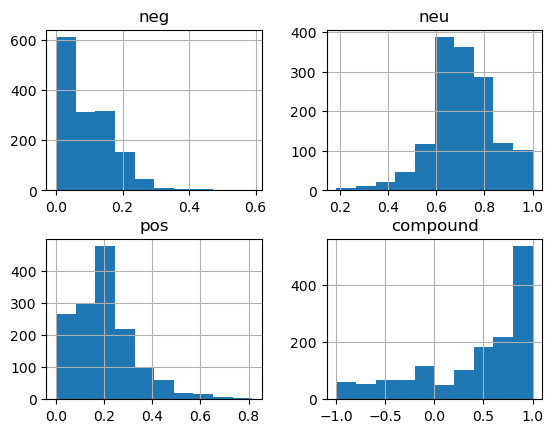

In [21]:
# plt.figure(figsize=(20, 5))

comments_withscores[['neg', 'neu', 'pos','compound']].hist(bins = 10)

# plt.savefig("project_data/output/sentiment.jpg", dpi = 200)

## Topic Modeling using LDA

In [22]:
# Selecting only comments from the df

docs = select_comments['processtext']
docs

2       21st century cure act absolutely patient waiti...
3       practicing physician , strongly support propos...
4       concerned `` recovering cost reasonably incurr...
5       apis exposed limited . giving patient role hea...
6       section c. i. proposed adoption fhir dstu2 sta...
                              ...                        
1905    100 % transparency health care pricing . 100 %...
1907    reason price medical care ca n't available eve...
1910    price healthcare available see , prudent choic...
1913                  like retail , total price available
1915    wide discrepancy pricing healthcare service . ...
Name: processtext, Length: 1459, dtype: object

In [23]:
# Transforming the comments into Tf-idf

tfidf_vect = TfidfVectorizer(min_df=50, stop_words='english')
tfidf_comments = tfidf_vect.fit_transform(docs)
tfidf_comments.shape

(1459, 312)

In [24]:
# Initialise the LDA model from sklearn

LDA = LatentDirichletAllocation(n_components = 3, 
                                random_state = 77, 
                                learning_method = 'batch')

In [25]:
# document-topic matrix (probabilities)

theta_comments = LDA.fit_transform(tfidf_comments)
beta_comments = LDA.components_
beta_prob_comments = LDA.components_ / LDA.components_.sum(axis=1)[:, np.newaxis]

In [26]:
# Function to return top words from each topic

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message, '\n')
    print()

In [27]:
# Evaluate the top words associated with each topic

features_comments = tfidf_vect.get_feature_names_out()

print_top_words(model = LDA, feature_names = features_comments, n_top_words = 20)

Topic #0: patient record medical onc information certified federal transparency effort decade physician hhs electronic suspension privacy risk american control health care 

Topic #1: patient data information health rule stop government ehrs sharing proposed purpose standard ehr program burden electronic control comment safety technology 

Topic #2: price cost healthcare insurance care transparency health hospital need service know medical pricing pay make procedure time doctor provider company 




In [28]:
# Visualise the topics using pyLDA

pyLDAvis.lda_model.prepare(LDA, tfidf_comments, tfidf_vect)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.275701 -0.022514       1        1  57.130122
0     -0.168954 -0.138418       2        1  26.049494
1     -0.106748  0.160932       3        1  16.820384, topic_info=           Term        Freq       Total Category  logprob  loglift
194     patient  146.000000  146.000000  Default  30.0000  30.0000
63         data   41.000000   41.000000  Default  29.0000  29.0000
54         cost   99.000000   99.000000  Default  28.0000  28.0000
239      record   55.000000   55.000000  Default  27.0000  27.0000
112  government   32.000000   32.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
26     blocking   11.527092   19.640257   Topic3  -4.5001   1.2497
228      public   10.734379   16.597445   Topic3  -4.5713   1.3468
53      control   13.055236   34.917714   Topic3  -4.3756   0.7988
277     support   11.771032   38.515796   Topic3  -4.4791   0.5972
239      record   11.646004   55.102451   Topic3  -4.4898   0.2283

[185 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1         1  0.966178      able
2         1  0.676218    access
2         2  0.186543    access
2         3  0.139907    access
3         2  0.941939     actor
...     ...       ...       ...
302       3  0.939513  valuable
308       2  0.950547   welcome
310       1  0.975488      work
310       3  0.039020      work
311       1  0.968972      year

[211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

## Named Entity Recognition using spaCy

In [29]:
# Initialise the model from spacy

nlp = spacy.load("en_core_web_sm")

In [30]:
# Merging all the comments into a single string

merged_comments = ''.join(select_comments['processtext'])
# merged_comments

"21st century cure act absolutely patient waiting development medical product , think proposed rule great advance medical field le burden cost .practicing physician , strongly support proposed rule - particular requirement health developer prohibit restrict communication regarding health ( i.e . `` gag rule '' ) . correct removing prohibition allow better transparent communication improve health , security , usability , safety , importantly benefit patient care . thanks much , ross filice , m.d .concerned `` recovering cost reasonably incurred '' regulation around information blocking , resulting impact competition long-run goal interoperability . simply put , hhs 's proposed rule disincentive investment interop technology . reality today health developer created technology required facilitate data liquidity desired scale . attribute reason : 1. massive investment required accommodate lack standard variability customer demand - every health system want something different . 2. investme

In [31]:
# Applying the model to the all the comments

doc = nlp(merged_comments)

In [32]:
# Visualising the tagging of NER

spacy.displacy.render(doc, style = "ent", jupyter = True)

/Users/ceciljohn/anaconda3/lib/python3.11/site-packages/spacy/displacy/__init__.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display


In [33]:
# Calculate the number of words tagged as NER per entity category

entity_counts = {}

for ent in doc.ents:
    entity_type = ent.label_
    
    if entity_type in entity_counts:
        entity_counts[entity_type] += 1
    else:
        entity_counts[entity_type] = 1

# Print the entity counts
for entity_type, count in entity_counts.items():
    print(f"{entity_type}: {count}")

DATE: 1003
PERSON: 273
CARDINAL: 1233
ORDINAL: 172
ORG: 541
NORP: 361
GPE: 186
MONEY: 580
QUANTITY: 19
PERCENT: 79
TIME: 93
PRODUCT: 11
LANGUAGE: 6
LAW: 1
LOC: 4
EVENT: 2
WORK_OF_ART: 1


## Examining the Proposed Rule for which comments were made

In [34]:
# Load the file

url = "https://downloads.regulations.gov/HHS-ONC-2019-0002-0001/content.htm"
html = request.urlopen(url).read().decode('utf8')
raw = BeautifulSoup(html, 'html.parser').get_text()
raw

"\n\nFederal Register, Volume 84 Issue 42 (Monday, March 4, 2019)\n\n\n[Federal Register Volume 84, Number 42 (Monday, March 4, 2019)]\n[Proposed Rules]\n[Pages 7424-7610]\nFrom the Federal Register Online via the Government Publishing Office [www.gpo.gov]\n[FR Doc No: 2019-02224]\n\n\n\n[[Page 7423]]\n\nVol. 84\n\nMonday,\n\nNo. 42\n\nMarch 4, 2019\n\nPart II\n\n\n\n\n\nDepartment of Health and Human Services\n\n\n\n\n\n-----------------------------------------------------------------------\n\n\n\n\n\nCenters for Medicare & Medicaid Services\n\n\n\n\n\n42 CFR Parts 406, 407, 422, et al.\n\n45 CFR Parts 156, 170, and 171\n\n\n\n\n\n21st Century Cures Act: Interoperability, Information Blocking, and the \nONC Health IT Certification Program; Medicare and Medicaid Programs; \nPatient Protection and Affordable Care Act; Interoperability and \nPatient Access for Medicare Advantage Organization and Medicaid Managed \nCare Plans, State Medicaid Agencies, CHIP Agencies and CHIP Managed \nCare

In [35]:
# Function to return specific portions of the raw file

def select_text(raw, start_pattern, end_pattern):

    start_match = re.search(start_pattern, raw)
    end_match = re.search(end_pattern, raw)

    start_index = start_match.end()
    end_index = end_match.start()

    portion_of_text = raw[start_index:end_index].strip().replace('\n', '')
        
    return portion_of_text

In [36]:
# Declare the portion of interest

start_pattern = r"Page 7510"
end_pattern = r"Page 7610"

In [37]:
rule_text = select_text(raw, start_pattern, end_pattern)
rule_text

"]]    We note that for the purpose of developing an exception for reasonable and necessary privacy-protective practices, we have distinguished between interferences that are ``required by law'' and those engaged in pursuant to a privacy law, but which are not ``required by law.'' The former does not fall within the definition of information blocking, but the latter may implicate the information blocking provision and an exception may be necessary. For a detailed discussion of this topic, please see section VIII.D.2 of this preamble.2. Health Care Providers, Health IT Developers, Exchanges, and Networks    Section 3022(a)(1) of the PHSA, in defining information blocking, refers to four classes of individuals and entities that may engage in information blocking and which include: Health care providers, health IT developers of certified health IT, networks, and exchanges. We propose to adopt definitions of these terms to provide clarity regarding the types of individuals and entities to 

In [38]:
# Applying NER to the rule

rule = nlp(rule_text)

In [39]:
# Visualising the results

spacy.displacy.render(rule, style = "ent", jupyter = True)

/Users/ceciljohn/anaconda3/lib/python3.11/site-packages/spacy/displacy/__init__.py:69: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display
